## Reasoning over models

In [1]:
# required modules (under Anaconda use: > conda install -c conda-forge <package>)
if False: # (skip if already installed)
    !pip install lark-parser
    !pip install linear-tree
    !pip install pydot
    !pip install pydotplus
    # download and install SWI Prolog from https://www.swi-prolog.org/download/stable
    # be sure that the executable is added to the PATH

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# standard imports
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
import matplotlib.pyplot as plt
import pydotplus
from IPython.display import Image

# imported packages
from lineartree import LinearTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# local imports
sys.path.append('../src/') # local path
import reasonx
import dautils

### Example on continuous only attributes

In [3]:
continuous_only = False

### Read dataframe

In [4]:
# read dataset
df = pd.read_csv('../data/adult_continuous.csv', na_values='?')
# remove unused columns
del df['fnlwgt']
del df['education-num']
# simplify dataframe
del df['marital-status']
del df['native-country']
del df['occupation']
del df['relationship']
# remove special characters in column names and values
df.columns = df.columns.str.replace("[-&()]", "", regex=True)
df = df.replace('[-&()]', '', regex=True)
# missing values imputation with mode (needed for Decision Trees)
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           48842 non-null  int64 
 1   workclass     48842 non-null  object
 2   education     48842 non-null  object
 3   race          48842 non-null  object
 4   sex           48842 non-null  object
 5   capitalgain   48842 non-null  int64 
 6   capitalloss   48842 non-null  int64 
 7   hoursperweek  48842 non-null  int64 
 8   class         48842 non-null  object
dtypes: int64(4), object(5)
memory usage: 3.4+ MB


In [5]:
df

,age,workclass,education,race,sex,capitalgain,capitalloss,hoursperweek,class
0,39,Stategov,Bachelors,White,Male,2174,0,40,<=50K
1,50,Selfempnotinc,Bachelors,White,Male,0,0,13,<=50K
2,38,Private,HSgrad,White,Male,0,0,40,<=50K
3,53,Private,11th,Black,Male,0,0,40,<=50K
4,28,Private,Bachelors,Black,Female,0,0,40,<=50K
...,...,...,...,...,...,...,...,...,...
48837,39,Private,Bachelors,White,Female,0,0,36,<=50K
48838,64,Private,HSgrad,Black,Male,0,0,40,<=50K
48839,38,Private,Bachelors,White,Male,0,0,50,<=50K
48840,44,Private,Bachelors,AsianPacIslander,Male,5455,0,40,<=50K


In [6]:
# nominal-ordinal-continuous partition of predictive attributes
nominal_atts = [] if continuous_only else ['race', 'sex', 'workclass']
ordinal_atts = [] if continuous_only else ['education']
continuous_atts = ['age', 'capitalgain', 'hoursperweek'] if continuous_only else ['age', 'capitalgain', 'capitalloss', 'hoursperweek']
# class attribute
target = 'class'
# predictive atts
pred_atts = nominal_atts + ordinal_atts + continuous_atts

In [7]:
# forcing encoding of ordinal attributes (consistent with the order) and class attribute (0=negatives, 1=positives)
decode = {
    'education': {
        1:'Preschool', 2:'1st4th', 3:'5th6th', 4:'7th8th', 5:'9th', 6:'10th', 7:'11th',
        8:'12th', 9:'HSgrad', 10:'Somecollege', 11:'Assocvoc', 12:'Assocacdm', 13:'Bachelors', 
        14:'Masters', 15:'Profschool', 16:'Doctorate' 
    },
    'class': {
        0: '<=50K', 1: '>50K'
    }
}
# encode nominal (as categories), ordinal+target (as int), passing the encoding of ordinal+target
prefix_sep = "_" # separator for one-hot encoding
df_code = dautils.Encode(nominal=nominal_atts, ordinal=ordinal_atts+[target], decode=decode, onehot=True, prefix_sep=prefix_sep)
df_encoded_onehot = df_code.fit_transform(df)
df_encoded_onehot.head()

,age,workclass_Federalgov,workclass_Localgov,workclass_Neverworked,workclass_Private,workclass_Selfempinc,workclass_Selfempnotinc,workclass_Stategov,workclass_Withoutpay,education,...,race_AsianPacIslander,race_Black,race_Other,race_White,sex_Female,sex_Male,capitalgain,capitalloss,hoursperweek,class
0,39,0,0,0,0,0,0,1,0,13,...,0,0,0,1,0,1,2174,0,40,0
1,50,0,0,0,0,0,1,0,0,13,...,0,0,0,1,0,1,0,0,13,0
2,38,0,0,0,1,0,0,0,0,9,...,0,0,0,1,0,1,0,0,40,0
3,53,0,0,0,1,0,0,0,0,7,...,0,1,0,0,0,1,0,0,40,0
4,28,0,0,0,1,0,0,0,0,13,...,0,1,0,0,1,0,0,0,40,0


In [8]:
# encoded atts names
encoded_pred_atts = df_code.encoded_atts(pred_atts)
# split predictive and target
X, y = df_encoded_onehot[encoded_pred_atts], df_encoded_onehot[target]
#X1, _, y1, _ = train_test_split(X, y, test_size=0.3, random_state=42)
#X2, _, y2, _ = train_test_split(X, y, test_size=0.3, random_state=24)

# retain test sets
X1, XT1, y1, yt1 = train_test_split(X, y, test_size=0.3, random_state=42)

# train different models
mlp = MLPClassifier(random_state=0)
mlp.fit(X1, y1)
mlp_label = mlp.predict(XT1)

rf = RandomForestClassifier(random_state = 0, max_depth=3, n_estimators=100)
rf.fit(X1, y1)
rf_label = rf.predict(XT1)

xgb = XGBClassifier(random_state = 0)
xgb.fit(X1, y1)
xgb_label = xgb.predict(XT1)

clf1 = DecisionTreeClassifier(max_depth=3)
clf1.fit(X1, y1)

# simple performance comparison of models
print("DT (case a)      ", clf1.score(XT1, yt1))
print("MLP              ", mlp.score(XT1, yt1))
print("RF               ", rf.score(XT1, yt1))
print("XGB              ", xgb.score(XT1, yt1))

# split the test set (XT1/xgb_labels) in two parts
XT1_train, XT1_test, xgb_label_train, xgb_label_test = train_test_split(XT1, xgb_label, test_size=0.3, random_state=42)
#print(len(XT1_train), len(XT1_test))

# train a surrogate decision tree
clf2 = DecisionTreeClassifier(max_depth=3)
clf2.fit(XT1_train, xgb_label_train)

# fidelity of the surrogate tree
print("fidelity         ", clf2.score(XT1_test, xgb_label_test))

DT (case a)       0.801610591687709
MLP               0.8137582747560227
RF                0.8083668873268273
XGB               0.8514297413498942
fidelity          0.9187898089171974


In [9]:
print(type(XT1_test), type(xgb_label_test))
pd_series = pd.Series(xgb_label_test)
#print(type(pd_series))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


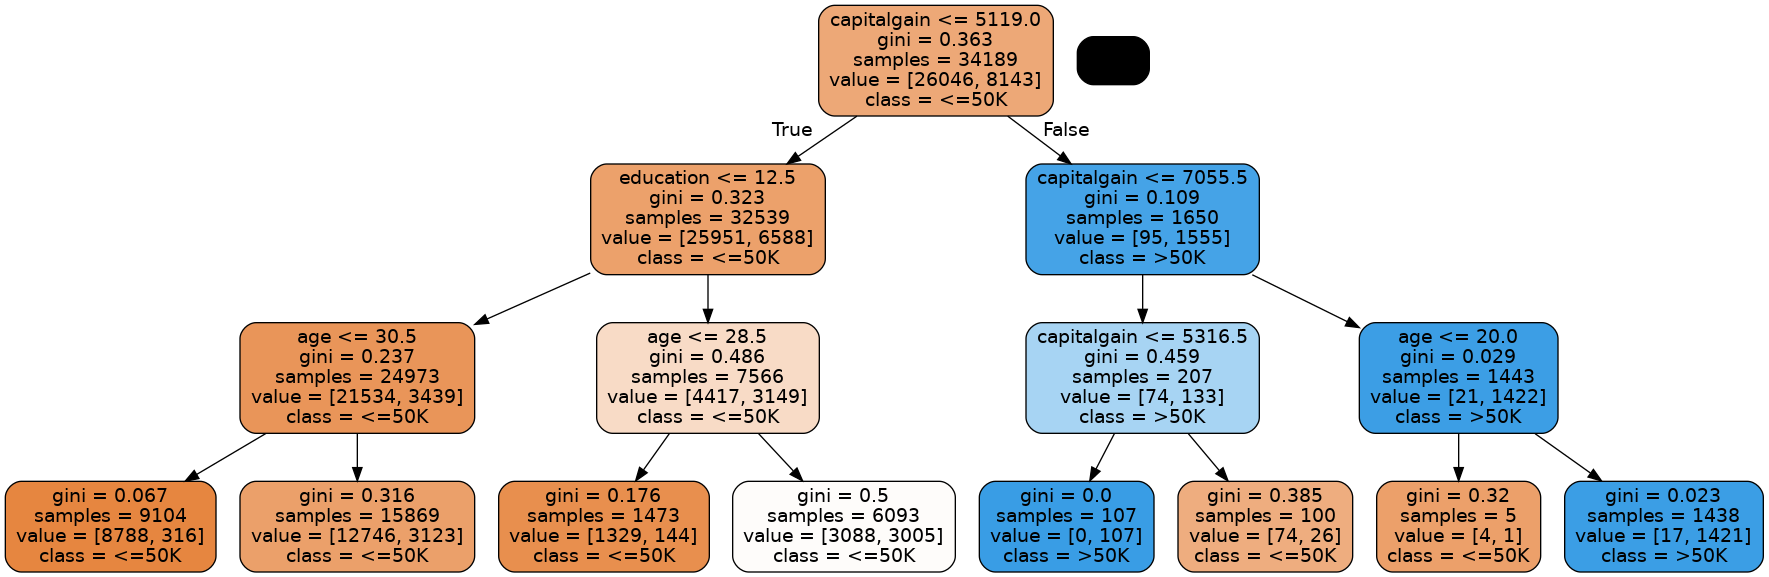

In [10]:
# visualize the decision tree
dot_data = tree.export_graphviz(clf1, out_file=None, 
                                feature_names=encoded_pred_atts, # attributes names
                                class_names=df_code.decode[target], # class labels
                                filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [11]:
# visualize the decision tree
#dot_data = tree.export_graphviz(clf2, out_file=None, 
#                                feature_names=encoded_pred_atts, # attributes names
#                                class_names=df_code.decode[target], # class labels
#                                filled=True, rounded=True)  
#graph = pydotplus.graph_from_dot_data(dot_data)  
#Image(graph.create_png())

In [12]:
# equality constraints on all features
def constraints(att_, pred_atts):
    const = ""
    for i in range(len(pred_atts)):
        #if att in pred_atts[i]:
        if any(pred_atts[i] in att for att in att_):
            continue
        else:
            const_i = "F0." + pred_atts[i] + " = " + "F1." + pred_atts[i]
            if len(const) == 0:
                #const = '"' + const + const_i
                const = const + const_i
            else:
                const = const + ", " + const_i
    return const

con = constraints([], pred_atts)
#print(con)

F0.race = F1.race, F0.sex = F1.sex, F0.workclass = F1.workclass, F0.education = F1.education, F0.age = F1.age, F0.capitalgain = F1.capitalgain, F0.capitalloss = F1.capitalloss, F0.hoursperweek = F1.hoursperweek


### Experiment

In [14]:
# Model2CLP
r = reasonx.ReasonX(pred_atts, target, df_code)
r.model(clf1)
r.model(clf2)

# diff models but compare over SAME data instace
# factual decision rule
r.instance('F0', features=XT1_test.iloc[2:3], label=pd_series.iloc[2], model = 0)
r.instance('F1', features=XT1_test.iloc[2:3], label=pd_series.iloc[2], model = 1)
r.solveopt()

#print("\ncombined \n")
#r.constraint(con)
#r.solveopt()

F0.race = White, F0.sex = Male, F0.workclass = Private, F0.education = Assocacdm, F0.age = 37, F0.capitalgain = 7688, F0.capitalloss = 0, F0.hoursperweek = 50
F1.race = White, F1.sex = Male, F1.workclass = Private, F1.education = Assocacdm, F1.age = 37, F1.capitalgain = 7688, F1.capitalloss = 0, F1.hoursperweek = 50
---
Answer constraint: F0.race=White,F0.sex=Male,F0.workclass=Private,F0.education=12.0,F0.age=37.0,F0.capitalgain=7688.0,F0.capitalloss=0.0,F0.hoursperweek=50.0,F1.race=White,F1.sex=Male,F1.workclass=Private,F1.education=12.0,F1.age=37.0,F1.capitalgain=7688.0,F1.capitalloss=0.0,F1.hoursperweek=50.0
Rule satisfied by F0: IF F0.capitalgain>7055.5,F0.age>20.0 THEN >50K [0.9882]
Rule satisfied by F1: IF F1.education<=12.5,F1.capitalgain>7073.5 THEN >50K [0.9940]
---
Answer constraint: F0.race=White,F0.sex=Male,F0.workclass=Private,F0.education=12.0,F0.age=37.0,F0.capitalgain=7688.0,F0.capitalloss=0.0,F0.hoursperweek=50.0,F1.race=White,F1.sex=Male,F1.workclass=Private,F1.educat

In [18]:
r.reset(keep_model=True)
r.instance('F1', features=XT1_test.iloc[2:3], label=pd_series.iloc[2], model = 1)
r.instance('CF1', label=1-pd_series.iloc[2], model = 1)

print("optimization")
answer_cons, a, b, c, d, e = r.solveopt(evaluation=1, return_results=1, eps=0.01)

print("------------")

r.reset(keep_model=True)
r.instance('F0', features=XT1_test.iloc[2:3], label=pd_series.iloc[2], model = 0)
r.instance('CF0', label=1-pd_series.iloc[2], model = 0)

print("optimization")
answer_cons, a, b, c, d, e = r.solveopt(evaluation=1, return_results=1, eps=0.01)

F1.race = White, F1.sex = Male, F1.workclass = Private, F1.education = Assocacdm, F1.age = 37, F1.capitalgain = 7688, F1.capitalloss = 0, F1.hoursperweek = 50
optimization
---
Answer constraint: F1.race=White,F1.sex=Male,F1.workclass=Private,F1.education=12.0,F1.age=37.0,F1.capitalgain=7688.0,F1.capitalloss=0.0,F1.hoursperweek=50.0,CF1.education<=12.5,CF1.capitalgain<=4243.5,CF1.capitalloss<=1805.0
Rule satisfied by F1: IF F1.education<=12.5,F1.capitalgain>7073.5 THEN >50K [0.9940]
Rule satisfied by CF1: IF CF1.education<=12.5,CF1.capitalgain<=4243.5,CF1.capitalloss<=1805.0 THEN <=50K [0.9760]
---
Answer constraint: F1.race=White,F1.sex=Male,F1.workclass=Private,F1.education=12.0,F1.age=37.0,F1.capitalgain=7688.0,F1.capitalloss=0.0,F1.hoursperweek=50.0,CF1.education>12.5,CF1.sex_Female<=0.5,CF1.age<=29.5
Rule satisfied by F1: IF F1.education<=12.5,F1.capitalgain>7073.5 THEN >50K [0.9940]
Rule satisfied by CF1: IF CF1.education>12.5,CF1.sex_Female<=0.5,CF1.age<=29.5 THEN <=50K [0.9474]


In [20]:
# COMBINATORIAL

# a - number of solutions
# b - distance (only for opt)
# c - number of premises in rule
# d - number of constraints in "answer constraints"
# e - dimensionality check (only for opt)

r.reset(keep_model=True)
r.instance('F0', features=XT1_test.iloc[2:3], label=pd_series.iloc[2], model = 0)
r.instance('CF0', label=1-pd_series.iloc[2], model = 0, minconf=0.9)

print("optimization")
answer_cons, a, b, c, d, e = r.solveopt(evaluation=1, return_results=1, eps=0.01)

# push output into system and query for second instance

r.instance('F1', label=pd_series.iloc[2], model = 1)
r.instance('CF1', label=1-pd_series.iloc[2], model = 1, minconf=0.9)
# instance 0 shoud have same values as instance 1
r.constraint(con)

for i in range(2):
    print("CONTRASTIVE RULE ", i)
    # contraints on instance 0 must be also valid for instance 1
    constraints_ = answer_cons[i][1].replace("CF0", "CF1")
    r.constraint(constraints_)
    print(constraints_)
    # query
    answer_cons_, a_, b_, c_, d_, e_ = r.solveopt(evaluation=1, return_results=1, project=["CF1"])
    print(a_)

    answer_cons_, a_, b_, c_, d_, e_ = r.solveopt(minimize='l1norm(F1, CF1)', evaluation=1, return_results=1, project=["CF1"], eps=0.01)
    print(a_,b_)

    r.retract(constraints_)

F0.race = White, F0.sex = Male, F0.workclass = Private, F0.education = Assocacdm, F0.age = 37, F0.capitalgain = 7688, F0.capitalloss = 0, F0.hoursperweek = 50
optimization
---
Answer constraint: F0.race=White,F0.sex=Male,F0.workclass=Private,F0.education=12.0,F0.age=37.0,F0.capitalgain=7688.0,F0.capitalloss=0.0,F0.hoursperweek=50.0,CF0.capitalgain<=5119.0,CF0.education<=12.5,CF0.age<=30.5
Rule satisfied by F0: IF F0.capitalgain>7055.5,F0.age>20.0 THEN >50K [0.9882]
Rule satisfied by CF0: IF CF0.capitalgain<=5119.0,CF0.education<=12.5,CF0.age<=30.5 THEN <=50K [0.9653]
---
Answer constraint: F0.race=White,F0.sex=Male,F0.workclass=Private,F0.education=12.0,F0.age=37.0,F0.capitalgain=7688.0,F0.capitalloss=0.0,F0.hoursperweek=50.0,CF0.capitalgain<=5119.0,CF0.education>12.5,CF0.age<=28.5
Rule satisfied by F0: IF F0.capitalgain>7055.5,F0.age>20.0 THEN >50K [0.9882]
Rule satisfied by CF0: IF CF0.capitalgain<=5119.0,CF0.education>12.5,CF0.age<=28.5 THEN <=50K [0.9022]
CONTRASTIVE RULE  0
CF1.ca